## Identify hand-drawn digits prototype v3

### Imports

In [11]:
import torch
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

### Hyperparameters and datasets

In [12]:
INPUT_SIZE: int = 28 * 28
CLASS_CNT: int = 10
TRAIN_BATCH_SZ: int = 100
TEST_BATCH_SZ: int = 1000
EPOCHS: int = 5
LEARN_RATE = 0.001

torch.manual_seed(42)

transformation = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)

training_set: datasets.EMNIST = datasets.EMNIST(
    root= "./data",
    train= True,
    download= True,
    transform= transformation,
    split= "byclass"
)

test_set: datasets.EMNIST = datasets.EMNIST(
    root= "./data",
    train= False,
    download= True,
    transform= transformation,
    split= "byclass"
)

train_load: DataLoader = DataLoader(
    dataset= training_set,
    batch_size= TRAIN_BATCH_SZ,
    shuffle= True,
    pin_memory= True,
    num_workers= 4
)

test_load: DataLoader = DataLoader(
    dataset= test_set,
    batch_size= TEST_BATCH_SZ,
    shuffle= False,
    pin_memory= True,
    num_workers= 4
)

device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Demo Training Data

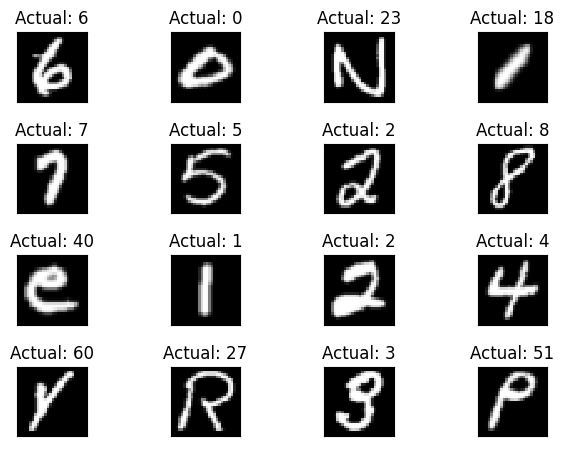

In [13]:
load_enumerate = enumerate(train_load)
idx, (demo_data, demo_target) = next(load_enumerate)

fig: plt.figure = plt.figure()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    plt.imshow(demo_data[i][0].t(), cmap= "gray", interpolation= "none")
    plt.title(f"Actual: {demo_target[i]}")
    plt.xticks([])
    plt.yticks([])


### Model Definition

In [14]:
class Digitv3Network(nn.Module):
    def __init__(self):
        super(Digitv3Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, 7, bias=False)    # output becomes 22x22
        self.conv1_bn = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 96, 7, bias=False)   # output becomes 16x16
        self.conv2_bn = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 144, 7, bias=False)  # output becomes 10x10
        self.conv3_bn = nn.BatchNorm2d(144)
        self.conv4 = nn.Conv2d(144, 192, 7, bias=False) # output becomes 4x4
        self.conv4_bn = nn.BatchNorm2d(192)
        self.fc1 = nn.Linear(3072, 62, bias=False) # 192 * 16 = 3072
        self.fc1_bn = nn.BatchNorm1d(62)
    def get_logits(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        flat1 = torch.flatten(conv4.permute(0, 2, 3, 1), 1)
        logits = self.fc1_bn(self.fc1(flat1))
        return logits
    def forward(self, x):
        logits = self.get_logits(x)
        return F.log_softmax(logits, dim=1)

model = Digitv3Network().to(device)
print(model)

Digitv3Network(
  (conv1): Conv2d(1, 48, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (conv1_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 96, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(96, 144, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (conv3_bn): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(144, 192, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (conv4_bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3072, out_features=62, bias=False)
  (fc1_bn): BatchNorm1d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Training the model

In [15]:
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss().cuda()
optimizer: torch.optim.SGD = torch.optim.SGD(model.parameters(), lr= LEARN_RATE)

n_steps = len(train_load)

for epoch in range(EPOCHS):
    for i, (img, label) in enumerate(train_load):
        img = img.to(device, non_blocking= True)
        label = label.to(device, non_blocking= True)
        # forward pass
        output = model(img)
        loss: torch.Tensor = criterion(output, label).to(device)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % TRAIN_BATCH_SZ == 0:
            print(f"Epoch {epoch + 1}/{EPOCHS}, step {i + 1}/{n_steps}, loss = {loss.item():.4f}")

Epoch 1/5, step 100/6980, loss = 2.1110
Epoch 1/5, step 200/6980, loss = 2.0172
Epoch 1/5, step 300/6980, loss = 1.8227
Epoch 1/5, step 400/6980, loss = 1.7616
Epoch 1/5, step 500/6980, loss = 1.5119
Epoch 1/5, step 600/6980, loss = 1.5976
Epoch 1/5, step 700/6980, loss = 1.4120
Epoch 1/5, step 800/6980, loss = 1.3844
Epoch 1/5, step 900/6980, loss = 1.3085
Epoch 1/5, step 1000/6980, loss = 1.3831
Epoch 1/5, step 1100/6980, loss = 1.2442
Epoch 1/5, step 1200/6980, loss = 1.2785
Epoch 1/5, step 1300/6980, loss = 1.3741
Epoch 1/5, step 1400/6980, loss = 1.1987
Epoch 1/5, step 1500/6980, loss = 1.3621
Epoch 1/5, step 1600/6980, loss = 1.1444
Epoch 1/5, step 1700/6980, loss = 1.3691
Epoch 1/5, step 1800/6980, loss = 1.2382
Epoch 1/5, step 1900/6980, loss = 1.2539
Epoch 1/5, step 2000/6980, loss = 0.9600
Epoch 1/5, step 2100/6980, loss = 1.0192
Epoch 1/5, step 2200/6980, loss = 1.1858
Epoch 1/5, step 2300/6980, loss = 1.0416
Epoch 1/5, step 2400/6980, loss = 1.1383
Epoch 1/5, step 2500/6980

### Testing the model

In [16]:
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_load:
        img = img.to(device, non_blocking= True)
        labels = labels.to(device, non_blocking= True)
        
        output = model(img)
        _, prediction = torch.max(output, 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

    acc = 100.0 * correct / total
    print(f"Accuracy: {acc}%")

Accuracy: 86.33288343663764%


### Save

In [17]:
torch.save(model.state_dict(), "./digitsv3_emnist.pth")

### Model Demo

torch.Size([1000, 1, 28, 28])
Predicted: 12
Actual: 12


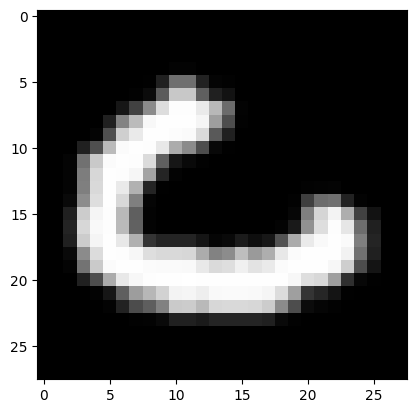

In [18]:
with torch.no_grad():
    i, (img, label) = next(enumerate(test_load))
    print(img.shape)
    img = img.to(device)
    label = label.to(device)
    idx = int(np.random.rand() * TEST_BATCH_SZ)
    output: torch.Tensor = model(img)

    outlist = [i.item() for i in list(output[idx])]
    print(f"Predicted: {outlist.index(max(outlist))}")
    print(f"Actual: {label[idx]}")
    plt.imshow(img[idx][0].cpu().t(), cmap= "gray", interpolation= "none")
